In [2]:
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

import notebook_style
labels = notebook_style.labels

#### Constants
kelvin = 273.15
R = 8.314472

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparison-of-different-RTM6-cure-models" data-toc-modified-id="Comparison-of-different-RTM6-cure-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison of different RTM6 cure models</a></span><ul class="toc-item"><li><span><a href="#Cure-model-comparison" data-toc-modified-id="Cure-model-comparison-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cure model comparison</a></span></li><li><span><a href="#Model-parameters" data-toc-modified-id="Model-parameters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model parameters</a></span></li><li><span><a href="#Compare-at-isothermal-cure" data-toc-modified-id="Compare-at-isothermal-cure-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Compare at isothermal cure</a></span></li></ul></li></ul></div>

# Comparison of different RTM6 cure models

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2020_

    Code under MIT license, all other material under CC-BY-3.0 license

In lesson 01 we examined and numerically used the cure model for RTM6 by Robert Hein et al, DLR:

> Exner, Wibke; Hein, Robert; Mahrholz, Thorsten; Wierach, Peter; Monner, Hans Peter; Sinapius, Michael (2018): _Impact of nanoparticles on the process-induced distortions of carbon fiber reinforced plastics. An experimental and simulative approach._ In: J. Appl. Polym. Sci. 43 (14), S. 47031. DOI: https://doi.org/10.1002/app.47031

In this lesson we will compare this model with those of other authors. 

One is Karkanas (PhD thesis):

> Karkanas, P. (1998): _Cure modelling and monitoring of epoxy/amine
resin systems_, PhD thesis, Cranfield University

And the other one is Pantelelis:

> Pantelelis, Nikos (2005): _Towards the dynamic optimisation for the cure control of thermoset–matrix composite materials_ In: Composites Science and Technology - COMPOSITES SCI TECHNOL. 65. 1254-1263. DOI: https://doi.org/10.1016/j.compscitech.2004.12.030. 

Note: We will compare the models without the $X_{max}$ expression as they are not availabe for the other models. 

## Cure model comparison

In [3]:
def arrhenius(A, E, T):
    """Calculate Arrhenius factor k"""
    return A*np.exp(-E / R / T)
def arrhenius_facors(temp, model_parameters):
    """Calculate both arrhenius factos k1 and k2 for temperature temp and the model"""
    T = temp + kelvin
    A1 = model_parameters["A1"]
    EA1 = model_parameters["EA1"]
    A2 = model_parameters["A2"]
    EA2 = model_parameters["EA2"]
    return arrhenius(A1, EA1, T), arrhenius(A2, EA2, T)
def interpol_tempcycle(t, cycle):
    """Return temperature at time t in cycle by linear interpolation"""
    return np.interp(t, cycle[:,0], cycle[:,1])
def reaction_model(X, t, cycle, model_parameters):  
    """Calculate reaction rate, input function for numerical integration"""
    temp = interpol_tempcycle(t, cycle)
    k1, k2 = arrhenius_facors(temp, model_parameters)
    m = model_parameters["m"]
    l = model_parameters["l"]
    n = model_parameters["n"]
    X = min(X, 1)
    return k1 * (1-X)**l + k2 * X**m * (1-X)**n

## Model parameters

In [4]:
Hein_2018 = dict(A1=np.exp(11.149), EA1=75549, 
                 A2=np.exp(8.762), EA2=50911, 
                 l=.489, m=1.549, n=2.179)

Pantelelis_2005 = dict(A1=2.54e4, EA1=71.46e3, 
                       A2=6.05e4, EA2=61.25e3, 
                       l=.492, m=1.252, n=1.75)

Karkanas_1998 = dict(A1=2.6e4, EA1=74.69e3, 
                     A2=5.78e4, EA2=57.88e3, 
                     l=.449, m=1.217, n=1.786)

## Compare at isothermal cure

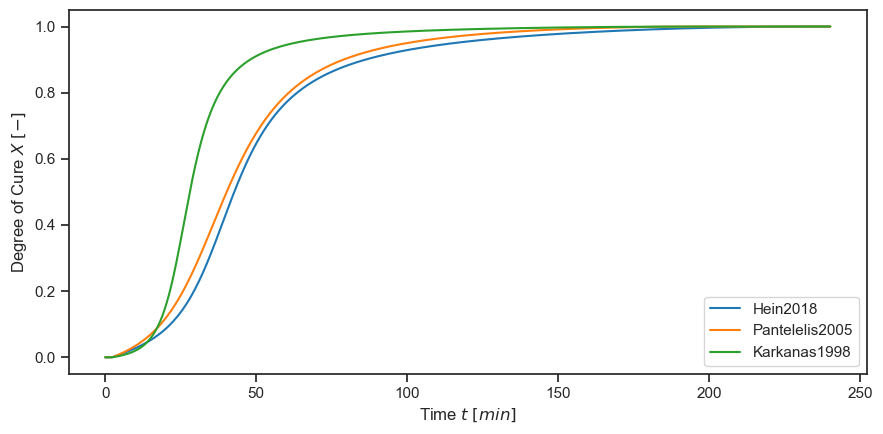

In [8]:
#### Modeling Parameters
# Cure temperature [°C]
T = 160
# Degree of Cure at beginning
X0 = 0
# end time of simulation [s]
t_max = 4*3600
# Number of time steps
N = 1001
# evenly spaced time vector for output
t = np.linspace(0, t_max, N)
# Make an array for temperature of same length
T_array = np.ones(N) * T

#### Solve Partial Equation of Cure Reaction at time steps t
X_Hein_2018 = np.ravel(odeint(reaction_model, X0, t, 
                       args=(np.array([t, T_array]), Hein_2018))
                      )

X_Pantelelis_2005 = np.ravel(odeint(reaction_model, X0, t, 
                             args=(np.array([t, T_array]), Pantelelis_2005))
                            )


X_Karkanas_1998 = np.ravel(odeint(reaction_model, X0, t, 
                           args=(np.array([t, T_array]), Karkanas_1998))
                          )

plt.figure()
plt.plot(t/60, X_Hein_2018, label=r"Hein2018")
plt.plot(t/60, X_Pantelelis_2005, label=r"Pantelelis2005")
plt.plot(t/60, X_Karkanas_1998, label=r"Karkanas1998")

plt.xlabel(labels["time"])
plt.ylabel(labels["doc"])
plt.legend()
plt.tight_layout();